In [0]:
!pip install kaggle


In [0]:
!pip install -q kaggle

In [0]:
 !mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d shadabhussain/flickr8k

 99% 1.08G/1.09G [00:17<00:00, 53.1MB/s]
100% 1.09G/1.09G [00:17<00:00, 68.6MB/s]


In [0]:
!unzip flickr8k.zip

Archive:  flickr8k.zip
  inflating: Flickr_Data.zip         
  inflating: model_weights.h5        
  inflating: train_encoded_images.p  


In [0]:
!unzip Flickr_Data.zip -d Flickr_Data/

Archive:  Flickr_Data.zip
   creating: Flickr_Data/Flickr_Data/Flickr_TextData/
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/CrowdFlowerAnnotations.txt  
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/ExpertAnnotations.txt  
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt  
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt  
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt  
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.lemma.token.txt  
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt  
  inflating: Flickr_Data/Flickr_Data/Flickr_TextData/readme.txt  
   creating: Flickr_Data/Flickr_Data/flickr8ktextfiles/
 extracting: Flickr_Data/Flickr_Data/flickr8ktextfiles/flickr_8k_train_dataset.txt  
  inflating: Flickr_Data/Flickr_Data/flickr8ktextfiles/flickr_8k_val_dataset.txt  
   creating: Flickr_Data/Flickr_Data/Images/
  inflating: Flickr_Data/Flickr_

In [0]:
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions


In [0]:
captions=readTextFile("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")


In [0]:
captions=captions.split("\n")[:-1]


In [0]:
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [0]:
print(len(captions))

40460


In [0]:
#dictionary to map  each image with the captions it has

In [0]:

captions[0].split("\t")

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [0]:
descriptions={}

for x in captions:
    first,second=x.split("\t")
    img_name=first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
        
    descriptions[img_name].append(second)

In [0]:

descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

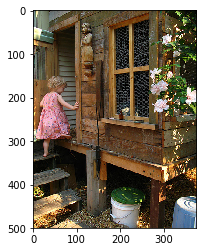

In [0]:
IMG_PATH="Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img=cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## Data Cleaning

In [0]:
import matplotlib.pyplot as plt
import keras
from keras import backend as K
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50  import ResNet50, preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [0]:
print(K.tensorflow_backend._get_available_gpus())





['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
def cleanText(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [0]:
cleanText("A cat is sitting over the house number 64")


'cat is sitting over the house number'

In [0]:
# clean all captions

for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=cleanText(caption_list[i])

In [0]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
# write the data to the text file

with open("descriptions.txt","w") as f:
    f.write(str(descriptions))


## Vocabulary

In [0]:
!pip install simplejson

     |████████████████████████████████| 81kB 6.5MB/s 
  Created wheel for simplejson: filename=simplejson-3.16.0-cp36-cp36m-linux_x86_64.whl size=114019 sha256=c0f9e7c01f3980b715ba51eb6413324c92e83d23887661cfac8dc6420984cc0f
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built simplejson


In [0]:
import simplejson as json

descriptions= None
with open("descriptions.txt",'r') as f:
    descriptions=f.read()
    
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)
                                            

In [0]:
#vocab
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]


In [0]:
len(vocab)

8424

In [0]:
total_words=[]

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

In [0]:
len(total_words)

373837

In [0]:
#filter words from the vocab according to a certain threshold frequency
import collections
counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [0]:
# sort this dictionary according to the freq count

sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#filter
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt ]

In [0]:

len(total_words)

1845

## Prepare train/test data

In [0]:
train_file_data=readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [0]:
train=[row.split(".")[0] for row in (train_file_data.split("\n"))[:-1]]
test=[row.split(".")[0] for row in (test_file_data.split("\n"))[:-1]]

In [0]:
#prepare description for the training data
#tweak- add a <s> and <e> token to our training data

train_descriptions={}

for img_id in train:
    
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq "+ cap+" endseq"
        train_descriptions[img_id].append(cap_to_append)

In [0]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## transfer learning

- Images--> Features
- text --> Features


## step1 Image Feature extraction

In [0]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()








102858752/102853048 [==============================] - 4s 0us/step


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_______________

In [0]:
model_new=Model(model.input,model.layers[-2].output)

In [0]:
import numpy as np
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    #normalisation
    img=preprocess_input(img)
    return img

In [0]:
#img=preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])

In [0]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
   
    feature_vector=feature_vector.reshape((2048,))
    #print(feature_vector.shape)
    return feature_vector

In [0]:
encode_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154311, 0.17076056, 0.29278564, ..., 0.05089615, 0.31322354,
       0.8600749 ], dtype=float32)

In [0]:
start=time()

encoding_train={}
#image_id-->feature_vector extracted from resnet50

for ix,img_id in enumerate(train):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print("encoding in progress time stamp %d"%ix)
        
end=time()
print("total_time taken:",end-start)

encoding in progress time stamp 0
encoding in progress time stamp 100
encoding in progress time stamp 200
encoding in progress time stamp 300
encoding in progress time stamp 400
encoding in progress time stamp 500
encoding in progress time stamp 600
encoding in progress time stamp 700
encoding in progress time stamp 800
encoding in progress time stamp 900
encoding in progress time stamp 1000
encoding in progress time stamp 1100
encoding in progress time stamp 1200
encoding in progress time stamp 1300
encoding in progress time stamp 1400
encoding in progress time stamp 1500
encoding in progress time stamp 1600
encoding in progress time stamp 1700
encoding in progress time stamp 1800
encoding in progress time stamp 1900
encoding in progress time stamp 2000
encoding in progress time stamp 2100
encoding in progress time stamp 2200
encoding in progress time stamp 2300
encoding in progress time stamp 2400
encoding in progress time stamp 2500
encoding in progress time stamp 2600
encoding in p

In [0]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [0]:
start=time()

encoding_test={}
#image_id-->feature_vector extracted from resnet50

for ix,img_id in enumerate(test):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print("encoding in progress time stamp %d"%ix)
        
end=time()
print("total_time taken:",end-start)

encoding in progress time stamp 0
encoding in progress time stamp 100
encoding in progress time stamp 200
encoding in progress time stamp 300
encoding in progress time stamp 400
encoding in progress time stamp 500
encoding in progress time stamp 600
encoding in progress time stamp 700
encoding in progress time stamp 800
encoding in progress time stamp 900
total_time taken: 32.050861120224


In [0]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## data pre-processing for captions

In [0]:
#vocab
len(total_words)

1845

In [0]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word
    
    

In [0]:
## two special words
idx_to_word[1846]="startseq"
word_to_idx["startseq"]=1846
word_to_idx["endseq"]=1847
idx_to_word[1847]="endseq"

vocab_size=len(word_to_idx)+1
print(vocab_size)

1848


In [0]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))

In [0]:
print(max_len)

35


## data loader(generator)

In [0]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y=[],[],[]
    n=0
    
    while True:
        for key,desc_list in train_descriptions.items():
            n+= 1
            photo= encoding_train[key]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(max(1, len(seq) - 1)):
                  xi=seq[0:i]
                  yi=seq[i]
                
                  #0 denote padding word
                  xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                  yi=to_categorical([yi],num_classes=vocab_size)[0]
                
                  X1.append(photo)
                  X2.append(xi)
                  y.append(yi)
                
                
            if n==batch_size:
                yield [np.array(X1) ,np.array(X2)] ,np.array(y)
                
                
                X1,X2,y=[],[],[]
                n=0
                

## Word Embeddings

In [0]:
!kaggle datasets download -d watts2/glove6b50dtxt

 90% 61.0M/67.7M [00:00<00:00, 53.9MB/s]
100% 67.7M/67.7M [00:00<00:00, 81.9MB/s]


In [0]:
!unzip glove6b50dtxt.zip

Archive:  glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


In [0]:
import numpy as np
f=open("glove.6B.50d.txt", encoding='utf8')

embedding_index={}

for line in f:
    values=line.split()
    
    word=values[0]
    embedding_word=np.array(values[1:],dtype='float')
    embedding_index[word]=embedding_word
    

In [0]:
f.close()

In [0]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [0]:
def get_embedding_matrix():
    emb_dim= 50
    matrix= np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix

In [0]:
word_to_idx['the']

2

In [0]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

## model architecture

In [0]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:

#captions as input
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)


In [0]:
## combined model
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
## important thing- embedding layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## training model

In [0]:

epochs=10
batch_size=3

steps=len(train_descriptions)

In [0]:
!mkdir model_weights

In [0]:
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save("./model_weights/model_"+str(i)+".h5")



Epoch 1/1
6000/6000 [==============================] - 745s 124ms/step - loss: 3.5910
Epoch 1/1
6000/6000 [==============================] - 745s 124ms/step - loss: 2.9307
Epoch 1/1
6000/6000 [==============================] - 741s 124ms/step - loss: 2.7272
Epoch 1/1
6000/6000 [==============================] - 740s 123ms/step - loss: 2.6127
Epoch 1/1
6000/6000 [==============================] - 747s 124ms/step - loss: 2.5369
Epoch 1/1
6000/6000 [==============================] - 745s 124ms/step - loss: 2.4816
Epoch 1/1
6000/6000 [==============================] - 743s 124ms/step - loss: 2.4383
Epoch 1/1
6000/6000 [==============================] - 753s 126ms/step - loss: 2.4066
Epoch 1/1
6000/6000 [==============================] - 743s 124ms/step - loss: 2.3785
Epoch 1/1
6000/6000 [==============================] - 739s 123ms/step - loss: 2.3593


In [0]:
 model.save("./model_weights/model_"+str(i)+".h5")

## predictions

In [0]:
def predict_caption(photo):
    in_text="startseq"
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax() #word with max prob always - greedy sampling
        word=idx_to_word[ypred]
        in_text +=(' '+ word)
        
        if word=="endseq":
            break
            
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    
    return final_caption

In [0]:
# pick some random images and see results

for i in range(15):
    idx=np.random.randint(0,1000)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo_2048=encoding_test[img_name].reshape((1,2048))
    
    i=plt.imread("Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    caption=predict_caption(photo_2048)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    print(caption)